In [1]:
!nvidia-smi

Mon Aug 21 14:57:57 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   59C    P8               7W /  50W |    794MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [3]:
image_size = 256
batch_size = 32
channels = 3
epochs = 50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (image_size, image_size),
    batch_size = batch_size
    )

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 2 0 1 1 1 0 0 0 1 1 0 0 1 1 1 1 0 0 2 0 1 0 0 0 1 1 1 1 1 1 0]


In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[188. 190. 202.]
  [188. 190. 202.]
  [189. 191. 203.]
  ...
  [244. 246. 255.]
  [131. 133. 145.]
  [154. 156. 168.]]

 [[203. 205. 217.]
  [200. 202. 214.]
  [194. 196. 208.]
  ...
  [153. 155. 167.]
  [167. 169. 181.]
  [116. 118. 130.]]

 [[192. 194. 206.]
  [189. 191. 203.]
  [184. 186. 198.]
  ...
  [109. 111. 123.]
  [127. 129. 141.]
  [162. 164. 176.]]

 ...

 [[153. 151. 165.]
  [155. 153. 167.]
  [160. 158. 172.]
  ...
  [102.  99. 118.]
  [ 72.  69.  88.]
  [121. 118. 137.]]

 [[151. 149. 163.]
  [151. 149. 163.]
  [157. 155. 169.]
  ...
  [108. 105. 124.]
  [159. 156. 175.]
  [102.  99. 118.]]

 [[152. 150. 164.]
  [151. 149. 163.]
  [155. 153. 167.]
  ...
  [151. 148. 167.]
  [ 74.  71.  90.]
  [116. 113. 132.]]]


In [9]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


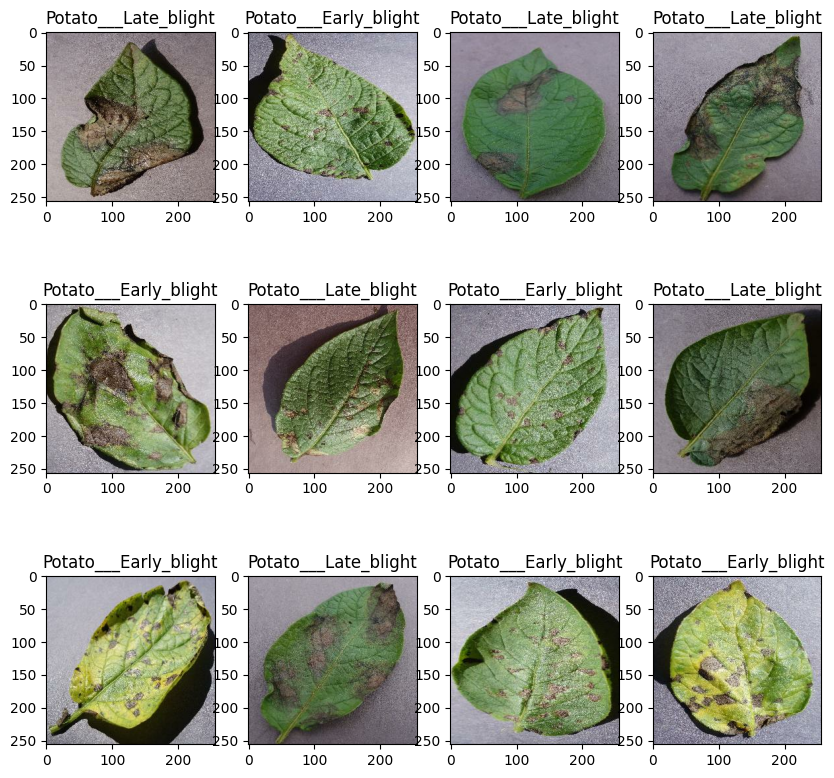

In [10]:
plt.figure(figsize=(10,10))

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        # plt.axis("off")
        

In [11]:
len(dataset)

68

In [12]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [13]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [14]:
train_ds = dataset.take(54)
len(train_ds)

54

In [15]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [16]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [17]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [18]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [19]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1,shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds 

In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [21]:
len(train_ds)

54

In [22]:
len(val_ds)

6

In [23]:
len(test_ds)

8

In [24]:
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size, image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)  
])

In [26]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [27]:
input_shape = (batch_size, image_size, image_size, channels)
n_classes = 3
model = models.Sequential([
    
    resize_rescale,
    data_augmentation,
    
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [28]:
 model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [29]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [30]:
history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 40s 461ms/step - loss: 0.8955 - accuracy: 0.4861 - val_loss: 0.9314 - val_accuracy: 0.4688
Epoch 2/50
54/54 [==============================] - 23s 426ms/step - loss: 0.6882 - accuracy: 0.7020 - val_loss: 0.5332 - val_accuracy: 0.7865
Epoch 3/50
54/54 [==============================] - 23s 426ms/step - loss: 0.4935 - accuracy: 0.7899 - val_loss: 0.3775 - val_accuracy: 0.8438
Epoch 4/50
30/54 [===============>..............] - ETA: 10s - loss: 0.4035 - accuracy: 0.8375

KeyboardInterrupt: 

In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 37ms/step - loss: 0.0355 - accuracy: 0.9883


In [ ]:
scores

[0.035545628517866135, 0.98828125]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.history['accuracy']

[0.4774305522441864,
 0.6331018805503845,
 0.8402777910232544,
 0.8790509104728699,
 0.8888888955116272,
 0.9224537014961243,
 0.9351851940155029,
 0.9456018805503845,
 0.9131944179534912,
 0.9629629850387573,
 0.9525462985038757,
 0.9710648059844971,
 0.9756944179534912,
 0.9594907164573669,
 0.9629629850387573,
 0.96875,
 0.9826388955116272,
 0.9681712985038757,
 0.9589120149612427,
 0.9606481194496155,
 0.9855324029922485,
 0.9722222089767456,
 0.9849537014961243,
 0.9791666865348816,
 0.9780092835426331,
 0.9855324029922485,
 0.9861111044883728,
 0.9866898059844971,
 0.9756944179534912,
 0.9618055820465088,
 0.9855324029922485,
 0.9866898059844971,
 0.9936342835426331,
 0.9959490895271301,
 0.9924768805503845,
 0.9971064925193787,
 0.9890046119689941,
 0.9976851940155029,
 0.9866898059844971,
 0.9826388955116272,
 0.9884259104728699,
 0.9866898059844971,
 0.9971064925193787,
 0.9959490895271301,
 0.9976851940155029,
 0.9976851940155029,
 0.9884259104728699,
 0.9739583134651184,
 0.

In [ ]:
len(history.history['accuracy'])

50

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

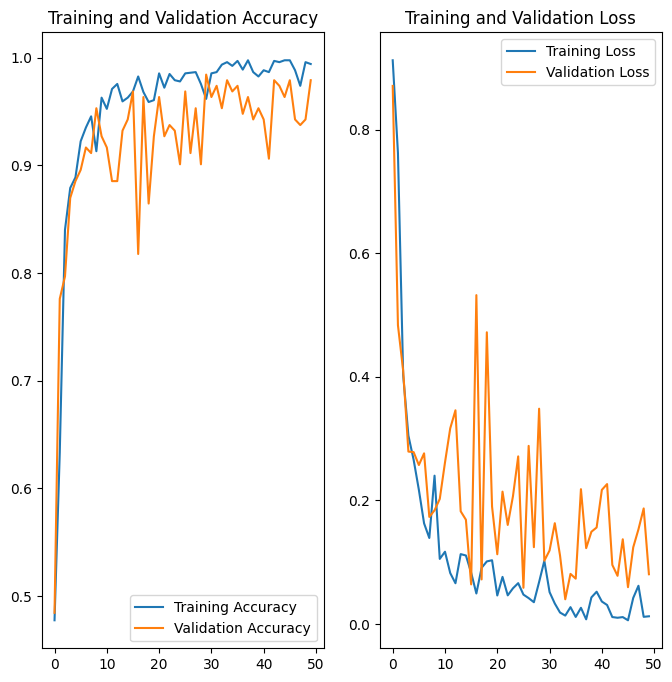

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual label: Potato___Late_blight
1/1 [==============================] - 0s 31ms/step
Predicted Label Potato___Late_blight


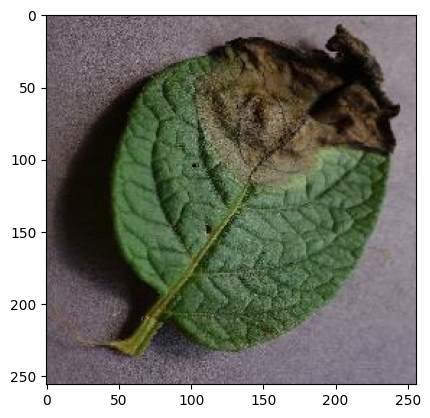

In [ ]:
for images_batch, label_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted Label",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.argmax(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


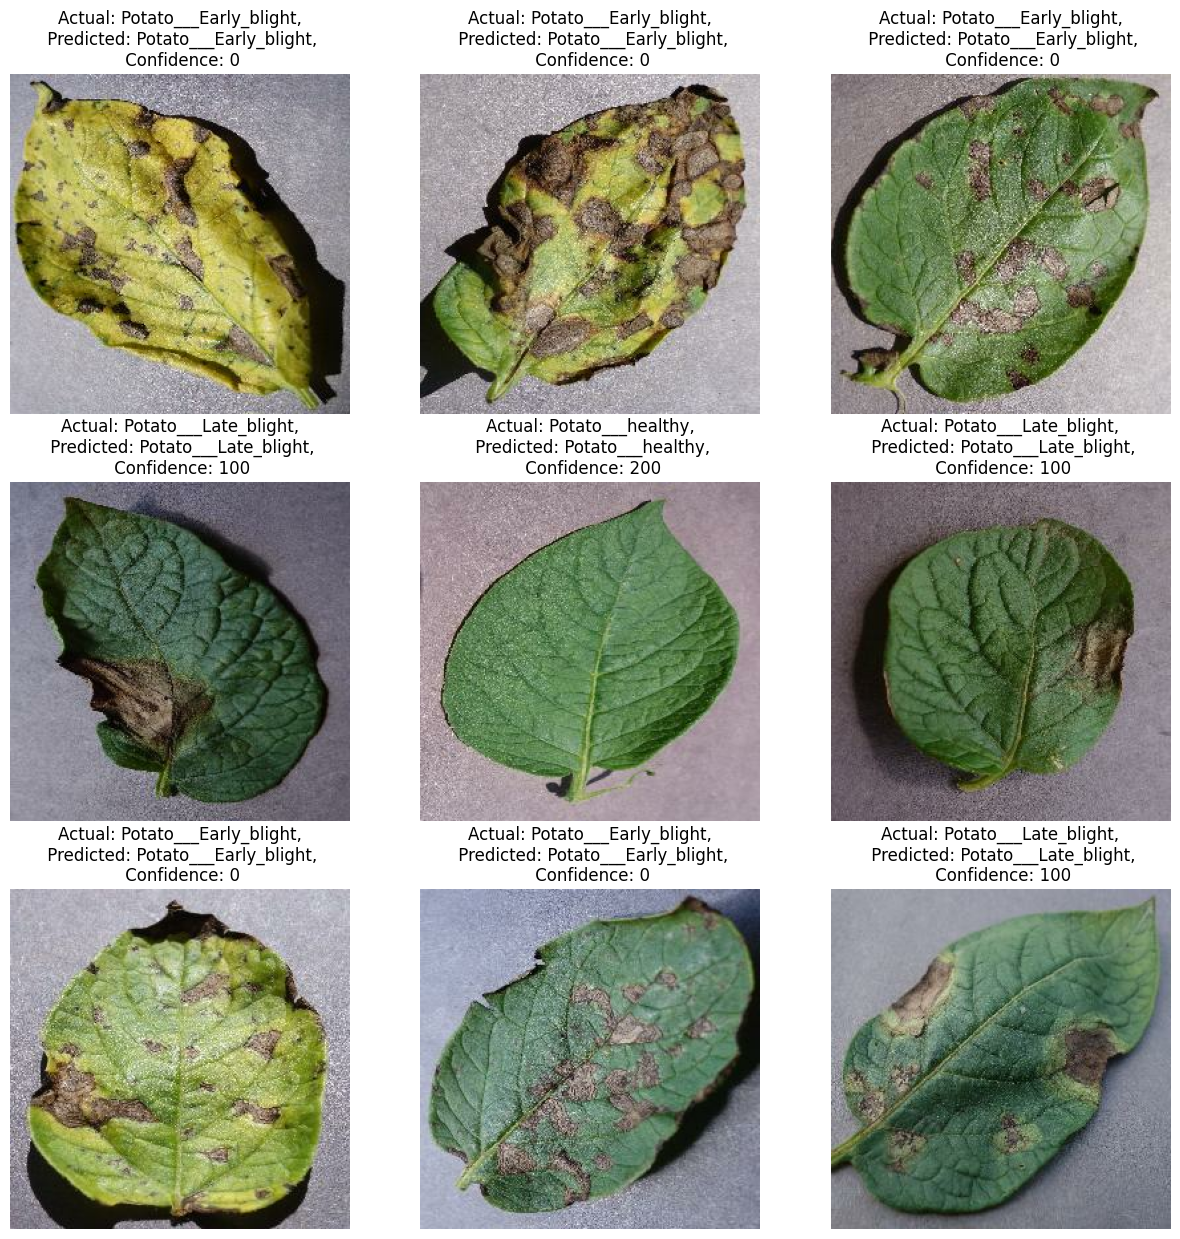

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f'Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}')

        plt.axis("off")

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [ ]:
model.save("../potatoes.h5") 